<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/RMS_Titanic_3.jpg/1024px-RMS_Titanic_3.jpg" width=400/>



In this notebook we will review Titanic problem.

The following sections will be discussed:
 - matplotlib/pandas basics
 - usage of sklearn for classification problem (logistic regression, random forest, svm)
 - cross-validation usage for hyperparameter tuning
 - mixing of different classifiers
 
Dataset can be downloaded from here:
https://www.kaggle.com/francksylla/titanic-machine-learning-from-disaster

In [23]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [26]:
!unzip "./data.zip" -d ./titanic

Archive:  ./data.zip
replace ./titanic/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [27]:
data = pd.read_csv("titanic/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
print("Size of dataset: {}".format(len(data)))
print("Number of survived: {}".format(len(data[data.Survived == 1])))

Size of dataset: 891
Number of survived: 342


In [29]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

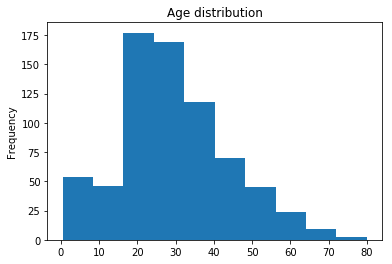

In [30]:
plt.title("Age distribution")
data["Age"].plot.hist()

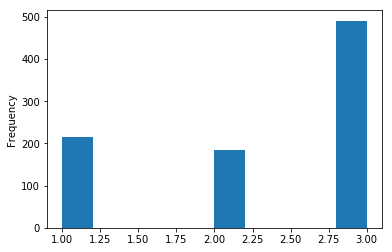

In [31]:
data["Pclass"].plot.hist()

In [32]:
data.Sex = data.Sex.map({'female':0,'male':1})

In [33]:
data = data.fillna(0)

In [34]:
data.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [35]:
features = data[['Sex', 'Age', "SibSp", "Parch", "Fare"]].values

In [36]:
train_X, test_X, train_y, test_y = train_test_split(features, data['Survived'].tolist(), test_size=0.2)

In [37]:
clf_log_reg = LogisticRegression()

In [38]:
clf_log_reg.fit(train_X, train_y)

/home/misha/ml-env-py3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

clf_log_reg.coef_

In [39]:
preds_logr_reg = clf_log_reg.predict_proba(test_X)[:,1]

In [40]:
sklearn.metrics.accuracy_score(preds_logr_reg > 0.5, test_y)

0.7877094972067039

In [41]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=13)

In [42]:
clf_rf.fit(train_X, train_y)
preds_rf = clf_rf.predict_proba(test_X)[:,1]
sklearn.metrics.accuracy_score(preds_rf > 0.5, test_y)

0.770949720670391

# Mixing of classifiers

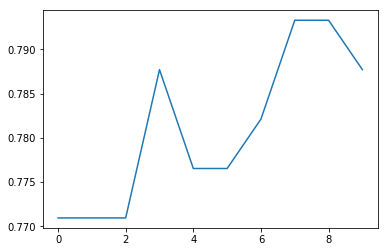

In [43]:
acc_list = []
for alpha in np.linspace(0, 1, 10):
    preds = alpha * preds_logr_reg + (1 - alpha) * preds_rf
    acc = sklearn.metrics.accuracy_score(preds > 0.5, test_y)
    acc_list.append(acc)
plt.plot(acc_list)

# Tuning of hyperparameters

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_depth' : [4, 7, 9, 13],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
CV_rfc.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [4, 7, 9, 13], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
CV_rfc.best_estimator_
CV_rfc.best_estimator_.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
preds_rf_tuned = CV_rfc.best_estimator_.predict_proba(test_X)[:,1]
sklearn.metrics.accuracy_score(preds_rf_tuned > 0.5, test_y)

0.7988826815642458

# Home task

- **3 points**: try tune other classifier (e.g. xgboost).
- **7 points**: try to mix xgboost, random forest and logistic regression. Find optimal proportion between them. don't forget to use cross validation.
- **20 points**: Let's try to create a model and become the best among Top 20% data scientists on unseen dataset here: https://www.kaggle.com/c/titanic/leaderboard.